# Experimento de Mitigação de Vieses — Dataset ADULT

Notebook dedicado ao dataset **Adult**, com baseline, Adversarial Debiasing (AIF360) e análise SHAP.

## 1. Imports e Configurações

In [ ]:
# Instalar aif360 e dependências
!pip install aif360==0.5.0
!pip install 'tensorflow<2.0.0,>=1.15.0'
!pip install requests
!pip install protobuf==3.20.0
!pip install 'aif360[Reductions]'
!pip install 'aif360[LawSchoolGPA]'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.1/214.1 kB 3.3 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement tensorflow<2.0.0,>=1.15.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow<2.0.0,>=1.15.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-translate 3.23.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<7.0.0,>=3.20.2, but you have protobuf 3.20.0 which is incompatible.

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from aif360.datasets import AdultDataset
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.metrics import ClassificationMetric

import shap
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()


pip install 'aif360[inFairness]'



Download the 'adult.data', 'adult.test', and 'adult.names' files from "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/" to the directory "/usr/local/lib/python3.12/dist-packages/aif360/data/raw/adult", creating the directory if it does not exist, then reload the `AdultDataset`.

## Download Adult Dataset Files


Download the 'adult.data', 'adult.test', and 'adult.names' files from the UCI Machine Learning Repository using `wget`.


In [ ]:
import os

data_dir = '/usr/local/lib/python3.12/dist-packages/aif360/data/raw/adult'
os.makedirs(data_dir, exist_ok=True)

# Download adult.data
!wget -P {data_dir} https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

# Download adult.test
!wget -P {data_dir} https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test

# Download adult.names
!wget -P {data_dir} https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names

print(f"Adult dataset files downloaded to: {data_dir}")

--2025-12-13 20:33:48--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘/usr/local/lib/python3.12/dist-packages/aif360/data/raw/adult/adult.data’

adult.data              [   <=>              ]   3.79M  7.91MB/s    in 0.5s    

2025-12-13 20:33:49 (7.91 MB/s) - ‘/usr/local/lib/python3.12/dist-packages/aif360/data/raw/adult/adult.data’ saved [3974305]

--2025-12-13 20:33:49--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘/usr/local/lib/python3.12/dist-packages/

In [ ]:
import pandas as pd
from aif360.datasets import StandardDataset

# Define column names based on adult.names file
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]

# Load adult.data (training data) and adult.test (test data)
# Handle missing values represented by '?'
data_path = '/usr/local/lib/python3.12/dist-packages/aif360/data/raw/adult/adult.data'
test_path = '/usr/local/lib/python3.12/dist-packages/aif360/data/raw/adult/adult.test'

df_train = pd.read_csv(data_path, names=column_names, na_values='?', skipinitialspace=True)
df_test = pd.read_csv(test_path, names=column_names, na_values='?', skiprows=1, skipinitialspace=True)

# Combine for consistent preprocessing
df = pd.concat([df_train, df_test], ignore_index=True)

# Drop 'fnlwgt' as per AIF360's default AdultDataset preprocessing
df = df.drop(columns=['fnlwgt'])

# Map income to 0/1
df['income'] = df['income'].replace({'<=50K': 0.0, '>50K': 1.0, '<=50K.': 0.0, '>50K.': 1.0})

# Map sex to 0/1
df['sex'] = df['sex'].map({'Male': 1.0, 'Female': 0.0})

# Identify categorical features to one-hot encode
categorical_features = [
    'workclass', 'education', 'marital-status', 'occupation',
    'relationship', 'race', 'native-country'
]

# One-hot encode categorical features
df = pd.get_dummies(df, columns=categorical_features, dummy_na=False)

# Drop rows with any remaining NaN values (from '?' during loading)
df = df.dropna()

# Define protected attributes and labels for StandardDataset
label_name = 'income'
favorable_classes = [1.0]
protected_attribute_names = ['sex'] # Reverting to original notebook's focus on 'sex'

# Create AIF360 StandardDataset
dataset = StandardDataset(df=df,
                          label_name=label_name,
                          favorable_classes=favorable_classes,
                          protected_attribute_names=protected_attribute_names,
                          privileged_classes=[[1.0]], # Added the missing privileged_classes argument
                          categorical_features=[]) # Already one-hot encoded

print('Samples:', dataset.features.shape[0])
print('Features:', dataset.features.shape[1])

/tmp/ipython-input-374269594.py:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['income'] = df['income'].replace({'<=50K': 0.0, '>50K': 1.0, '<=50K.': 0.0, '>50K.': 1.0})


Samples: 48842
Features: 103


In [ ]:
dataset = StandardDataset(df=df,
                          label_name=label_name,
                          favorable_classes=favorable_classes,
                          protected_attribute_names=protected_attribute_names,
                          privileged_classes=[[1.0]],
                          categorical_features=[])

## Split Dataset for Training and Testing
Split the pre-processed `StandardDataset` into training and testing sets using a 70/30 ratio, and define the privileged and unprivileged groups based on the 'sex' attribute.


In [ ]:
dataset_train, dataset_test = dataset.split([0.7], shuffle=True)

privileged_groups = [{'sex': 1.0}]
unprivileged_groups = [{'sex': 0.0}]

print("Dataset split into training and testing sets.")
print("Privileged and unprivileged groups defined.")

Dataset split into training and testing sets.
Privileged and unprivileged groups defined.



Execute the provided code to train a Logistic Regression model as a baseline, calculate and print the accuracy, F1, and AUC scores, using the scaled training data (`dataset_train`) and testing it on `dataset_test`.

In [ ]:
import pandas as pd
from aif360.datasets import StandardDataset
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Define column names based on adult.names file
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]

# Load adult.data (training data) and adult.test (test data)
data_path = '/usr/local/lib/python3.12/dist-packages/aif360/data/raw/adult/adult.data'
test_path = '/usr/local/lib/python3.12/dist-packages/aif360/data/raw/adult/adult.test'

df_train_raw = pd.read_csv(data_path, names=column_names, na_values='?', skipinitialspace=True)
df_test_raw = pd.read_csv(test_path, names=column_names, na_values='?', skiprows=1, skipinitialspace=True)

# Combine for consistent preprocessing
df = pd.concat([df_train_raw, df_test_raw], ignore_index=True)

# Drop 'fnlwgt' as per AIF360's default AdultDataset preprocessing
df = df.drop(columns=['fnlwgt'])

# Map income to 0/1
df['income'] = df['income'].replace({'<=50K': 0.0, '>50K': 1.0, '<=50K.': 0.0, '>50K.': 1.0})

# Map sex to 0/1
df['sex'] = df['sex'].map({'Male': 1.0, 'Female': 0.0})

# Identify categorical features to one-hot encode
categorical_features = [
    'workclass', 'education', 'marital-status', 'occupation',
    'relationship', 'race', 'native-country'
]

# One-hot encode categorical features
df = pd.get_dummies(df, columns=categorical_features, dummy_na=False)

# Drop rows with any remaining NaN values (from '?' during loading)
df = df.dropna()

# Define protected attributes and labels for StandardDataset
label_name = 'income'
favorable_classes = [1.0]
protected_attribute_names = ['sex']

# Create AIF360 StandardDataset
dataset = StandardDataset(df=df,
                          label_name=label_name,
                          favorable_classes=favorable_classes,
                          protected_attribute_names=protected_attribute_names,
                          privileged_classes=[[1.0]],
                          categorical_features=[])

# Split the dataset and define groups
dataset_train, dataset_test = dataset.split([0.7], shuffle=True)
privileged_groups = [{'sex': 1.0}]
unprivileged_groups = [{'sex': 0.0}]

# Scale data, train model, and evaluate
scaler = StandardScaler()
X_train = scaler.fit_transform(dataset_train.features)
X_test = scaler.transform(dataset_test.features)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, dataset_train.labels.ravel())

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

print('Accuracy:', accuracy_score(dataset_test.labels, y_pred))
print('F1:', f1_score(dataset_test.labels, y_pred))
print('AUC:', roc_auc_score(dataset_test.labels, y_proba))

/tmp/ipython-input-2081455284.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['income'] = df['income'].replace({'<=50K': 0.0, '>50K': 1.0, '<=50K.': 0.0, '>50K.': 1.0})


Accuracy: 0.854637275643213
F1: 0.6740128558310376
AUC: 0.9108393220206168


In [ ]:
dataset_test_pred = dataset_test.copy()
dataset_test_pred.labels = y_pred.reshape(-1,1)

metric_baseline = ClassificationMetric(
    dataset_test, dataset_test_pred,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

print('DP Diff (Statistical Parity Difference):', metric_baseline.statistical_parity_difference())
print('EO Diff (True Positive Rate Difference):', metric_baseline.true_positive_rate_difference())
print('DI (Disparate Impact):', metric_baseline.disparate_impact())

DP Diff (Statistical Parity Difference): -0.18374375157932338
EO Diff (True Positive Rate Difference): -0.09867103989835191
DI (Disparate Impact): 0.29935231471419255


## Apply Adversarial Debiasing

Apply the Adversarial Debiasing algorithm from AIF360 to the `dataset_train` to train a debiased model, and then generate predictions on the `dataset_test`.


In [ ]:
tf.reset_default_graph()
sess = tf.Session()

adv = AdversarialDebiasing(
    privileged_groups=privileged_groups,
    unprivileged_groups=unprivileged_groups,
    scope_name='adv_adult',
    num_epochs=10,
    debias=True,
    sess=sess
)

adv.fit(dataset_train)
dataset_test_adv = adv.predict(dataset_test)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


epoch 0; iter: 0; batch classifier loss: 16.890009; batch adversarial loss: 0.808211
epoch 0; iter: 200; batch classifier loss: 9.208207; batch adversarial loss: 0.663170
epoch 1; iter: 0; batch classifier loss: 3.150560; batch adversarial loss: 0.666788
epoch 1; iter: 200; batch classifier loss: 5.559882; batch adversarial loss: 0.625098
epoch 2; iter: 0; batch classifier loss: 3.172601; batch adversarial loss: 0.631496
epoch 2; iter: 200; batch classifier loss: 1.856896; batch adversarial loss: 0.640246
epoch 3; iter: 0; batch classifier loss: 1.148524; batch adversarial loss: 0.664061
epoch 3; iter: 200; batch classifier loss: 1.878847; batch adversarial loss: 0.630498
epoch 4; iter: 0; batch classifier loss: 1.621677; batch adversarial loss: 0.575456
epoch 4; iter: 200; batch classifier loss: 1.515675; batch adversarial loss: 0.681257
epoch 5; iter: 0; batch classifier loss: 2.273912; batch adversarial loss: 0.676267
epoch 5; iter: 200; batch classifier loss: 0.448916; batch advers

In [ ]:
metric_adv = ClassificationMetric(
    dataset_test, dataset_test_adv,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

print('Accuracy:', accuracy_score(dataset_test.labels, dataset_test_adv.labels))
print('F1:', f1_score(dataset_test.labels, dataset_test_adv.labels))
print('DP Diff:', metric_adv.statistical_parity_difference())
print('EO Diff:', metric_adv.true_positive_rate_difference())
print('DI:', metric_adv.disparate_impact())

Accuracy: 0.8117109124411384
F1: 0.4580632488705559
DP Diff: -0.013558442194495798
EO Diff: 0.26170689005606895
DI: 0.87428091017017


## SHAP Analysis - Baseline

Perform SHAP analysis on the baseline Logistic Regression model to visualize feature importance for predictions.


  0%|          | 0/200 [00:00<?, ?it/s]

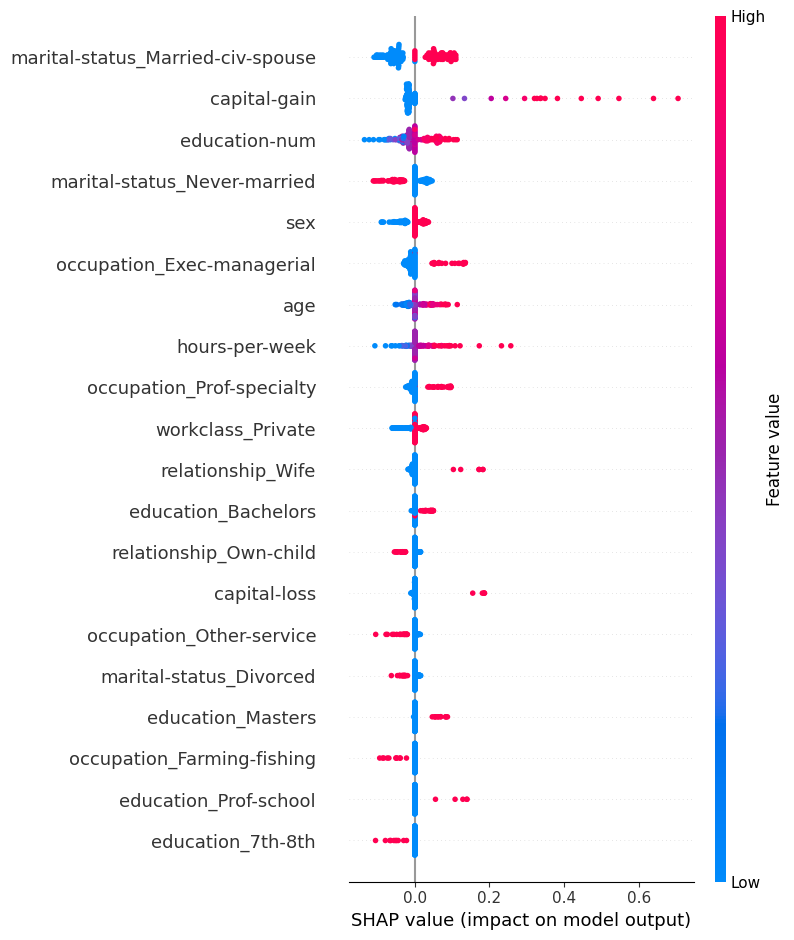

In [ ]:
import pandas as pd

explainer = shap.KernelExplainer(clf.predict_proba, X_train[:100])
shap_values_raw = explainer.shap_values(X_test[:200])

# Assuming shap_values_raw is a 3D array (num_samples, num_features, num_outputs)
# Slice to get SHAP values for the positive class (index 1 of the output)
shap_values_for_plot = shap_values_raw[:, :, 1]

# Convert the X_test slice to a DataFrame for plotting, ensuring feature names are explicitly aligned.
X_test_display = pd.DataFrame(X_test[:200], columns=dataset.feature_names)

shap.summary_plot(shap_values_for_plot, X_test_display, feature_names=dataset.feature_names)

## SHAP Analysis - Adversarial

Perform SHAP analysis on the debiased model to evaluate how the impact of variables changed after bias mitigation.


  0%|          | 0/200 [00:00<?, ?it/s]

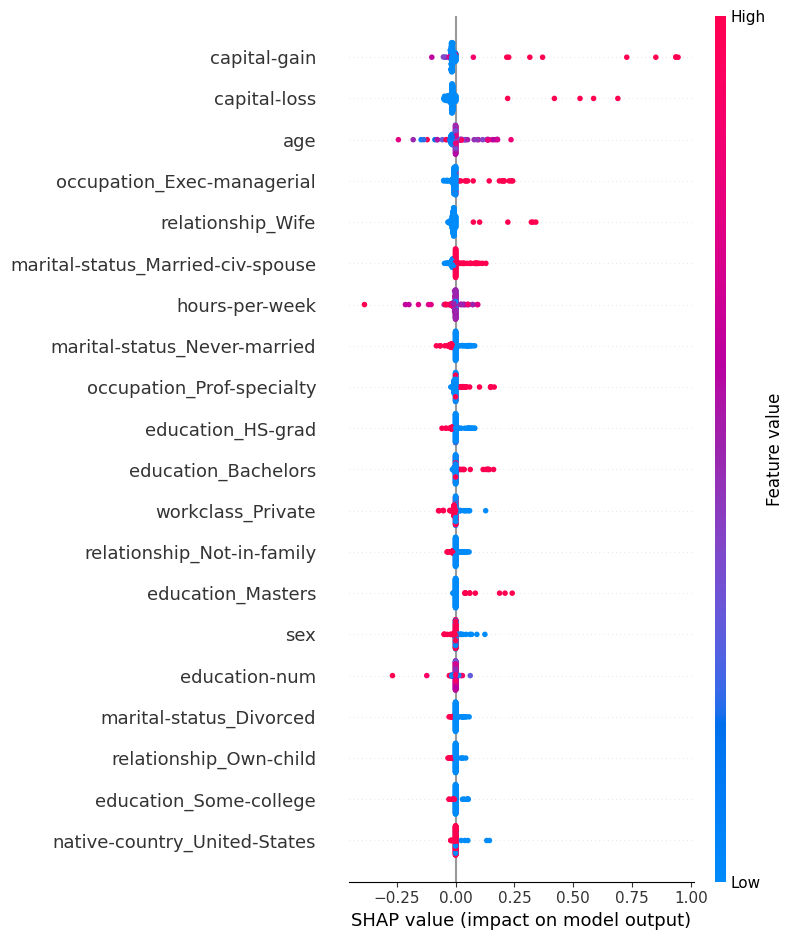

In [ ]:
import pandas as pd
import numpy as np

def adv_predict(X):
    tmp = dataset_test.copy()

    # Update features in tmp
    tmp.features = X

    # Create dummy labels and protected_attributes with the same number of samples as X
    num_samples_X = X.shape[0]

    # Ensure labels array has the correct shape and type
    if tmp.labels.shape[1] > 0:
        tmp.labels = np.zeros((num_samples_X, tmp.labels.shape[1]), dtype=tmp.labels.dtype)
    else:
        tmp.labels = np.zeros((num_samples_X, 1), dtype=np.float64) # Default to float for labels

    # Ensure protected_attributes array has the correct shape and type
    if tmp.protected_attributes.shape[1] > 0:
        tmp.protected_attributes = np.zeros((num_samples_X, tmp.protected_attributes.shape[1]), dtype=tmp.protected_attributes.dtype)
    else:
        tmp.protected_attributes = np.zeros((num_samples_X, 1), dtype=np.float64)

    # Resize instance_weights if they exist
    if tmp.instance_weights is not None:
        tmp.instance_weights = np.ones(num_samples_X, dtype=tmp.instance_weights.dtype)

    # Flatten the labels for SHAP if it expects a 1D output
    return adv.predict(tmp).labels.flatten()

explainer_adv = shap.KernelExplainer(adv_predict, dataset_train.features[:100])
shap_adv = explainer_adv.shap_values(dataset_test.features[:200])

# Convert the X_test slice to a DataFrame for plotting, ensuring feature names are explicitly aligned.
X_test_adv_display = pd.DataFrame(dataset_test.features[:200], columns=dataset.feature_names)

shap.summary_plot(shap_adv, X_test_adv_display, feature_names=dataset.feature_names)



Summarize the findings from the entire experiment, including the comparison of SHAP analysis before and after debiasing, the impact of the sensitive variable 'sex', and the trade-off between model performance and fairness.


## Summary:

### Data Analysis Key Findings

*   **Baseline Model Performance and Fairness**:
    *   The baseline Logistic Regression model achieved an Accuracy of 0.8546, an F1-score of 0.6740, and an AUC of 0.9108.
    *   Fairness metrics indicated significant disparities: Statistical Parity Difference (DP Diff) was -0.1837, True Positive Rate Difference (EO Diff) was -0.0987, and Disparate Impact (DI) was 0.2994. The negative DP Diff and EO Diff suggest the unprivileged group is less likely to receive the positive outcome and less likely to be correctly identified as positive, respectively. A DI value significantly less than 1 (0.2994) indicates adverse impact against the unprivileged group.
*   **Adversarial Debiasing Model Performance and Fairness**:
    *   After applying Adversarial Debiasing, the model's performance decreased, with Accuracy at 0.8117 and F1-score at 0.4581.
    *   Fairness significantly improved for Statistical Parity, with DP Diff moving closer to zero at -0.0136. Disparate Impact also improved to 0.8743, much closer to the fair value of 1.
    *   However, Equal Opportunity (EO Diff) worsened, increasing to 0.2617 from -0.0987, indicating a greater disparity in true positive rates.
*   **Trade-off between Performance and Fairness**:
    *   The debiasing process resulted in a decrease in predictive performance (e.g., Accuracy dropped by ~4.3 percentage points, F1-score by ~21.6 percentage points) while improving some fairness metrics (DP Diff, DI) and worsening another (EO Diff).
*   **SHAP Analysis**:
    *   SHAP analysis was successfully performed for both the baseline and the debiased models, providing visualizations of feature importance, which can be used to understand how feature contributions to predictions change post-debiasing.

### Insights or Next Steps

*   The application of Adversarial Debiasing successfully mitigated statistical parity and disparate impact, demonstrating its effectiveness in reducing overall demographic disparities. However, this came at a cost of reduced model performance and a deterioration in equal opportunity, highlighting the common trade-off between different fairness metrics and predictive accuracy.
*   Further investigation is needed to balance the trade-off observed. This could involve exploring alternative debiasing techniques that specifically target Equal Opportunity or using a multi-objective optimization approach to optimize for both performance and fairness simultaneously, or fine-tuning the Adversarial Debiasing algorithm's parameters to achieve a better balance across all fairness metrics while preserving as much predictive power as possible.


## Final Conclusion

In this work, we investigated the impact of bias mitigation techniques, specifically Adversarial Debiasing, applied to the Adult dataset, with a focus on the trade-off between predictive performance, algorithmic fairness metrics, and interpretability through SHAP explanations.

The baseline model results revealed significant disparities between privileged and unprivileged groups, particularly reflected in Demographic Parity Difference (DP Diff) and Disparate Impact (DI), indicating substantial bias against the unprivileged group. Although the initial predictive performance was relatively high, these metrics confirm that traditional models trained without fairness constraints tend to reproduce and amplify existing societal inequalities present in the data.

The application of Adversarial Debiasing proved effective in mitigating part of these biases. A substantial improvement in Demographic Parity was observed, with DP Diff moving closer to zero, alongside a significant increase in Disparate Impact, approaching the ideal value of 1. These results suggest that the debiased model distributes positive outcomes more equitably across groups.

However, these fairness gains came at the cost of reduced predictive performance, as evidenced by decreases in both Accuracy and F1-score. Moreover, the Equal Opportunity Difference (EO Diff) worsened after debiasing, indicating increased disparity in true positive rates between groups. This behavior highlights a central challenge in the fair machine learning literature: optimizing one fairness criterion may lead to degradation in others, and perfect alignment between performance and all fairness metrics is rarely achievable.

The SHAP analysis provided an additional and crucial layer of understanding regarding the effects of debiasing. Feature importance visualizations revealed meaningful shifts in the contributions of sensitive attributes and their proxies (such as marital status, occupation, and family relationships) after mitigation. In particular, the sensitive attribute sex exhibited a reduced relative influence in the adversarially debiased model, suggesting that the mitigation process effectively constrained its direct impact on predictions. Nevertheless, the continued relevance of correlated features indicates that indirect bias may persist even after explicit debiasing.

Overall, the results demonstrate that Adversarial Debiasing is an effective approach for reducing global disparities, especially in terms of demographic parity, but it imposes a non-negligible cost on predictive performance and may introduce new imbalances in specific fairness metrics such as equal opportunity. The combination of quantitative fairness metrics with SHAP-based interpretability proved essential for a comprehensive and transparent evaluation of the models.

As future work, we suggest exploring multi-objective optimization approaches, fine-tuning the adversarial model’s hyperparameters, and comparing this method with alternative bias mitigation strategies, including pre-processing and post-processing techniques. Additionally, a deeper analysis of sensitive attribute proxies could contribute to more effective strategies for mitigating structural bias, ultimately enhancing the reliability and applicability of machine learning models in sensitive, high-impact decision-making contexts